# _Hotel Project made by Alina Imansakipova_

According to the requirements, the final program must present and display a report of the result obtained for 4 strategies of allocating guests to the hotel rooms. Those strategies are:
* Random Allocation,
* Availability Allocation,
* Price Allocation,
* Preference Allocation.

The result should contain the number of customers accommodated, the number of rooms occupied, the number of different hotels occupied, the total volume of business (total earnings of each hotel), and the degree of customer satisfaction (calculated according to the location of the hotel assigned to them with respect to their preferences).

## The path and the files to be reviewed

**Alina.Imansakipova/hotel-project/hotel_project/final**

* __init__.py &#8592; contains the main code

following files contain classes fror each allocation strategy:
* __random_allocation_class.py__
* __availability_allocation_class.py__
* __price_allocation_class.py__
* __preferences_allocation_class.py__


following files contain functions for outputting the result:
* __output.py__ &#8592; contains the functions for presenting required statistics
* __vizualization.py__ &#8592; contains the funtion for vizualizing the results

* __streamlit_app.py__ &#8592; contains the streamlit application

__*This presentation*__ PLAN OF PRESENTATION

## Random Allocation Class

This class provides method of allocating guests and rooms randomly.

In [1]:
import pandas as pd
import numpy as np

class RandomHotelAllocator:
    def __init__(self, hotelsdata, guestdata, preferencesdata):
        self.hotelsdata = hotelsdata
        self.guestdata = guestdata
        self.preferencesdata = preferencesdata
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])
    
    # calculating satisfaction percentage of each guest according to allocation
    def calculate_satisfaction_percentage(self, guest_id, hotel_id):
        #retracting guests' preferences
        guest_preferences = self.preferencesdata[self.preferencesdata['guest'] == guest_id].reset_index()
        #if guest has no preferences, his satisfaction percentage is always 100
        if guest_preferences.empty:
            return 100

        #checking id given hotel is in guest's preferences
        is_hotel_one_of_preferred = np.isin(hotel_id, guest_preferences['hotel'].values)

        # if this hotel is in preferences than we calculate index of preferences
        if is_hotel_one_of_preferred.any():
            index_of_preference = np.argmax(guest_preferences['hotel'].values == hotel_id)
            guest_preferences_count = len(guest_preferences)
            return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
        else:
            return 0

    # Function for allocating random hotel
    def allocate_random_hotel(self, guest_id, guest_row):
        available_hotels = self.hotelsdata[self.hotelsdata['rooms'] > 0]
        if available_hotels.empty:
            return None
        
        #picking random hotel
        random_available_hotel_id = np.random.choice(available_hotels.index)
        #picking the room
        random_available_hotel_row = available_hotels.loc[random_available_hotel_id]
        #excluding the room from available
        random_available_hotel_row['rooms'] -= 1

        #calculating the price according to guest accomodated
        paid_price_coefficient = 1 - guest_row['discount']
        paid_price = random_available_hotel_row['price'] * paid_price_coefficient
        
        #calculating satisfaction percentage
        satisfaction = self.calculate_satisfaction_percentage(guest_id, random_available_hotel_id)

        return [guest_id, random_available_hotel_id, satisfaction, paid_price]
    
    # Random allocation
    def get_random_allocation(self):
        #shuffling guests
        shuffled_guests = self.guestdata.sample(frac=1, random_state=42)
        for guest_id, guest_row in shuffled_guests.iterrows():
            allocation_entry = self.allocate_random_hotel(guest_id, guest_row)
            if allocation_entry is not None:
                self.allocation.loc[len(self.allocation)] = allocation_entry

        return self.allocation

## Availability Allocation Class

This class allocates guests and rooms by availability, meaning the more free rooms hotel has, the more "available" it is. Also it considers guests' preferences as a factor of assigning.

In [2]:
class HotelAvailabilityAllocator:
    def __init__(self, hotelsdata, guestdata, preferencesdata):
        self.hotelsdata = hotelsdata
        self.guestdata = guestdata
        self.preferencesdata = preferencesdata
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    #the same function from class before
    # calculating satisfaction percentage of each guest according to allocation
    def calculate_satisfaction_percentage(self, guest_id, hotel_id):
        #retracting guests' preferences
        guest_preferences = self.preferencesdata[self.preferencesdata['guest'] == guest_id].reset_index()
        #if guest has no preferences, his satisfaction percentage is always 100
        if guest_preferences.empty:
            return 100

        #checking id given hotel is in guest's preferences
        is_hotel_one_of_preferred = np.isin(hotel_id, guest_preferences['hotel'].values)

        # if this hotel is in preferences than we calculate index of preferences
        if is_hotel_one_of_preferred.any():
            index_of_preference = np.argmax(guest_preferences['hotel'].values == hotel_id)
            guest_preferences_count = len(guest_preferences)
            return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
        else:
            return 0

    #Function for allocating preferred rooms for those who have preferences
    def allocate_preferred_rooms(self, hotel_id, hotel_row):
        #creating a variable where we keep preferences of the guest
        guests_who_preferred_hotel = self.preferencesdata[self.preferencesdata['hotel'] == hotel_id]['guest']
        # excluding allocated guests by using boolean expression: True if guest isn't accomodated, false otherwise
        guests_to_allocate = guests_who_preferred_hotel[~guests_who_preferred_hotel.isin(self.allocation['guest_id'])]

        hotel_available_rooms = hotel_row['rooms']

        for _, guest_id in guests_to_allocate.items():
            if hotel_available_rooms == 0:
                break
            #excluding room in which we put a guest
            hotel_available_rooms -= 1
            #finding the exact row of allocated guest to retract discount data            
            guest_row = self.guestdata.loc[guest_id]

            paid_price_coefficient = 1 - guest_row['discount']
            paid_price = hotel_row['price'] * paid_price_coefficient

            satisfaction = self.calculate_satisfaction_percentage(guest_id, hotel_id)

            self.allocation.loc[len(self.allocation)] = [guest_id, hotel_id, satisfaction, paid_price]

        return hotel_available_rooms
    #function for allocating the remaining rooms for those who don't have any preferences
    def allocate_remaining_rooms(self, hotel_available_rooms, hotel_id, hotel_row):
        guests_to_allocate = self.guestdata[~self.guestdata.index.isin(self.allocation['guest_id'])]

        for guest_id, guest_row in guests_to_allocate.iterrows():
            if hotel_available_rooms == 0:
                break

            hotel_available_rooms -= 1

            paid_price_coefficient = 1 - guest_row['discount']
            paid_price = hotel_row['price'] * paid_price_coefficient

            self.allocation.loc[len(self.allocation)] = [guest_id, hotel_id, 0, paid_price]

    def get_availability_allocation(self):
        #sorting hotels by availability meaning that the more rooms it has the more available it is
        sorted_hotels = self.hotelsdata.sort_values(by='rooms', ascending=False)

        for hotel_id, hotel_row in sorted_hotels.iterrows():
            hotel_remaining_rooms_count = self.allocate_preferred_rooms(hotel_id, hotel_row)
            if hotel_remaining_rooms_count > 0:
                self.allocate_remaining_rooms(hotel_remaining_rooms_count, hotel_id, hotel_row)

        return self.allocation

## Price Allocation Class

This class allocates guests and rooms based on the price of the rooms, prioritizing guests' preferences when assigning rooms.

In [3]:
class HotelPriceAllocator:
    def __init__(self, hotelsdata, guestdata, preferencesdata):
        self.hotelsdata = hotelsdata
        self.guestdata = guestdata
        self.preferencesdata = preferencesdata
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])
    
    # the same as it was
    # calculating satisfaction percentage of each guest according to allocation
    def calculate_satisfaction_percentage(self, guest_id, hotel_id):
        #retracting guests' preferences
        guest_preferences = self.preferencesdata[self.preferencesdata['guest'] == guest_id].reset_index()
        #if guest has no preferences, his satisfaction percentage is always 100
        if guest_preferences.empty:
            return 100

        #checking id given hotel is in guest's preferences
        is_hotel_one_of_preferred = np.isin(hotel_id, guest_preferences['hotel'].values)

        # if this hotel is in preferences than we calculate index of preferences
        if is_hotel_one_of_preferred.any():
            index_of_preference = np.argmax(guest_preferences['hotel'].values == hotel_id)
            guest_preferences_count = len(guest_preferences)
            return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
        else:
            return 0
    
    # Function that allocates rooms to guests who have specified a preference for the given hotel
    def allocate_preferred_rooms(self, hotel_id, hotel_row):
        guests_who_preferred_hotel = self.preferencesdata[self.preferencesdata['hotel'] == hotel_id]['guest']
        guests_to_allocate = guests_who_preferred_hotel[~guests_who_preferred_hotel.isin(self.allocation['guest_id'])]
        hotel_available_rooms = hotel_row['rooms']

        for _, guest_id in guests_to_allocate.items():
            if hotel_available_rooms == 0:
                break

            hotel_available_rooms -= 1
            guest_row = self.guestdata.loc[guest_id]

            paid_price_coefficient = 1 - guest_row['discount']
            paid_price = hotel_row['price'] * paid_price_coefficient

            satisfaction = self.calculate_satisfaction_percentage(guest_id, hotel_id)
            self.allocation.loc[len(self.allocation)] = [guest_id, hotel_id, satisfaction, paid_price]

        return hotel_available_rooms, self.allocation

    # Function that allocates remaining rooms to guests who did not have a specific preference for the hotel
    def allocate_remaining_rooms(self, hotel_available_rooms, hotel_id, hotel_row):
        guests_to_allocate = self.guestdata[~self.guestdata.index.isin(self.allocation['guest_id'])]
        for guest_id, guest_row in guests_to_allocate.iterrows():
            if hotel_available_rooms == 0:
                break

            hotel_available_rooms -= 1
            paid_price_coefficient = 1 - guest_row['discount']
            paid_price = hotel_row['price'] * paid_price_coefficient
            self.allocation.loc[len(self.allocation)] = [guest_id, hotel_id, 0, paid_price]

        return self.allocation

    def get_price_allocation(self):
        allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])
        #sorting hotels by price (ascending)
        sorted_hotels = self.hotelsdata.sort_values(by='price')

        for hotel_id, hotel_row in sorted_hotels.iterrows():
            hotel_remaining_rooms_count, allocation = self.allocate_preferred_rooms(hotel_id, hotel_row)
            if hotel_remaining_rooms_count > 0:
                allocation = self.allocate_remaining_rooms(hotel_remaining_rooms_count,  hotel_id, hotel_row)

        return allocation

## Preferences Allocation Class

The class allocates rooms to guests based on their preferred hotels.

In [4]:
class HotelPreferenceAllocator:
    def __init__(self, hotelsdata, guestdata, preferencesdata):
        self.hotelsdata = hotelsdata
        self.guestdata = guestdata
        self.preferencesdata = preferencesdata
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    # calculating satisfaction percentage of each guest according to allocation
    def calculate_satisfaction_percentage(self, guest_id, hotel_id):
        #retracting guests' preferences
        guest_preferences = self.preferencesdata[self.preferencesdata['guest'] == guest_id].reset_index()
        #if guest has no preferences, his satisfaction percentage is always 100
        if guest_preferences.empty:
            return 100

        #checking id given hotel is in guest's preferences
        is_hotel_one_of_preferred = np.isin(hotel_id, guest_preferences['hotel'].values)

        # if this hotel is in preferences than we calculate index of preferences
        if is_hotel_one_of_preferred.any():
            index_of_preference = np.argmax(guest_preferences['hotel'].values == hotel_id)
            guest_preferences_count = len(guest_preferences)
            return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
        else:
            return 0

    #Function allocates a room to a guest based on the guest's preferred hotels.
    def allocate_preferred_hotel(self, guest_id, guest_row):
        guest_preferred_hotels = self.preferencesdata[self.preferencesdata['guest'] == guest_id]['hotel']

        #Checking if there are available rooms in preferred hotel, calculating the price paid and satisfaction percentage
        for _, preferred_hotel_id in guest_preferred_hotels.items():
            preferred_hotel_row = self.hotelsdata.loc[preferred_hotel_id]

            if preferred_hotel_row['rooms'] > 0:
                preferred_hotel_row['rooms'] -= 1

                paid_price_coefficient = 1 - guest_row['discount']
                paid_price = preferred_hotel_row['price'] * paid_price_coefficient

                satisfaction = self.calculate_satisfaction_percentage(guest_id, preferred_hotel_id)

                return [guest_id, preferred_hotel_id, satisfaction, paid_price]

        return None
    
    #Allocation by preference through the all guests
    def get_customer_preference_allocation(self):
        self.allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

        for guest_id, guest_row in self.guestdata.iterrows():
            allocation_entry = self.allocate_preferred_hotel(guest_id, guest_row)
            if allocation_entry is not None:
                self.allocation.loc[len(self.allocation)] = allocation_entry

        return self.allocation

## Output

_This function presents required statistics such as_:
* Customers accomodated
* Number of rooms occupied
* Number of different hotels occupied
* Average satisfaction
* Total earnings per hotel

In [5]:
def allocation_analysis(allocation):
    #counting the guests accomodated
    print('Customers accomodated:', allocation['guest_id'].count())
    #amount of rooms occupied is the same as one room is assigned to only one guest
    print('Number of rooms occupied:', allocation['guest_id'].count())
    #counting the hotels occupied, since we have to count different hotels, nunique is used
    print('Number of different hotels occupied:', allocation['hotel_id'].nunique())
    #counting average satisfaction
    print('Average satisfaction:', round(allocation['satisfaction_percentage'].mean(),2))
    #creating new dataframe for presenting total earnings for each hotel
    total_earnings = allocation[['hotel_id', 'paid_price']].copy()
    print('Total earnings per hotel:', total_earnings.groupby('hotel_id').sum(), sep='\n')

## Vizualization

_This function presents 2 bar charts showing Total earnings per each Hotel and Satisfaction percentage per each Guest. However, in a main code 30 guests - is limitation for presenting._

In [6]:
import matplotlib.pyplot as plt

def visualize_allocation(allocation):
    #using 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Total earnings for each hotel
    paid_price_by_hotel = allocation.groupby('hotel_id')['paid_price'].sum()
    paid_price_by_hotel.plot(kind='bar', ax=ax1, title='Total Earnings by Hotel')
    ax1.set_xlabel('Hotel ID')
    ax1.set_ylabel('Total Earnings')

    # Plot 2: Satisfaction percentage for each guest
    satisfaction_by_guest = allocation.groupby('guest_id')['satisfaction_percentage'].mean()
    satisfaction_by_guest.plot(kind='bar', ax=ax2, title='Satisfaction Percentage by Guest')
    ax2.set_xlabel('Guest ID')
    ax2.set_ylabel('Satisfaction Percentage')

    fig.suptitle(f"number of customers/rooms = {str(len(allocation))}; number of hotels = {str(allocation['hotel_id'].nunique())}")

    plt.tight_layout()
    plt.show()

## Results obtained

### 1. Importing data

In [7]:
import pandas as pd
import openpyxl
hotelsdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/hotels.xlsx").set_index('hotel')
hotelsdata

,Unnamed: 0,rooms,price
hotel,,,
hotel_1,0,13,273
hotel_2,1,18,92
hotel_3,2,12,141
hotel_4,3,18,157
hotel_5,4,7,298
...,...,...,...
hotel_396,395,5,212
hotel_397,396,12,68
hotel_398,397,14,102


In [8]:
guestdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/guests.xlsx").set_index('guest')
guestdata

,Unnamed: 0,discount
guest,,
guest_1,0,0.09
guest_2,1,0.00
guest_3,2,0.07
guest_4,3,0.00
guest_5,4,0.10
...,...,...
guest_3996,3995,0.00
guest_3997,3996,0.15
guest_3998,3997,0.07


In [9]:
preferencesdata=pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/preferences.xlsx").drop_duplicates(subset=['guest','hotel'])
preferencesdata

,Unnamed: 0,guest,hotel,priority
0,0,guest_1,hotel_168,1
1,1,guest_1,hotel_207,2
2,2,guest_1,hotel_222,3
3,3,guest_1,hotel_124,4
4,4,guest_1,hotel_223,5
...,...,...,...,...
99528,99528,guest_4000,hotel_123,28
99529,99529,guest_4000,hotel_396,29
99530,99530,guest_4000,hotel_161,30
99531,99531,guest_4000,hotel_330,31


### 2. Analyzing data

No duplicates found

In [10]:
guestdata.value_counts(subset=['guest','discount'])

guest       discount
guest_1     0.09        1
guest_3402  0.07        1
guest_3391  0.06        1
guest_3392  0.07        1
guest_3393  0.17        1
                       ..
guest_2202  0.17        1
guest_2203  0.12        1
guest_2204  0.04        1
guest_2205  0.00        1
guest_999   0.15        1
Name: count, Length: 4000, dtype: int64

In [11]:
hotelsdata.value_counts(subset=['hotel','rooms','price'])

hotel      rooms  price
hotel_1    13     273      1
hotel_336  11     235      1
hotel_345  11     136      1
hotel_344  18     98       1
hotel_343  15     217      1
                          ..
hotel_216  6      212      1
hotel_215  9      133      1
hotel_214  9      79       1
hotel_213  14     256      1
hotel_99   6      187      1
Name: count, Length: 400, dtype: int64

### 3. Allocations
### a. Random Allocation

Start calculate random allocation
Customers accomodated: 4000
Number of rooms occupied: 4000
Number of different hotels occupied: 400
Average satisfaction: 3.04
Total earnings per hotel:
           paid_price
hotel_id             
hotel_1       2012.01
hotel_10      2402.04
hotel_100     1712.00
hotel_101     2017.66
hotel_102      659.92
...               ...
hotel_95      3167.33
hotel_96      1495.52
hotel_97      2436.48
hotel_98      1981.86
hotel_99      2028.95

[400 rows x 1 columns]


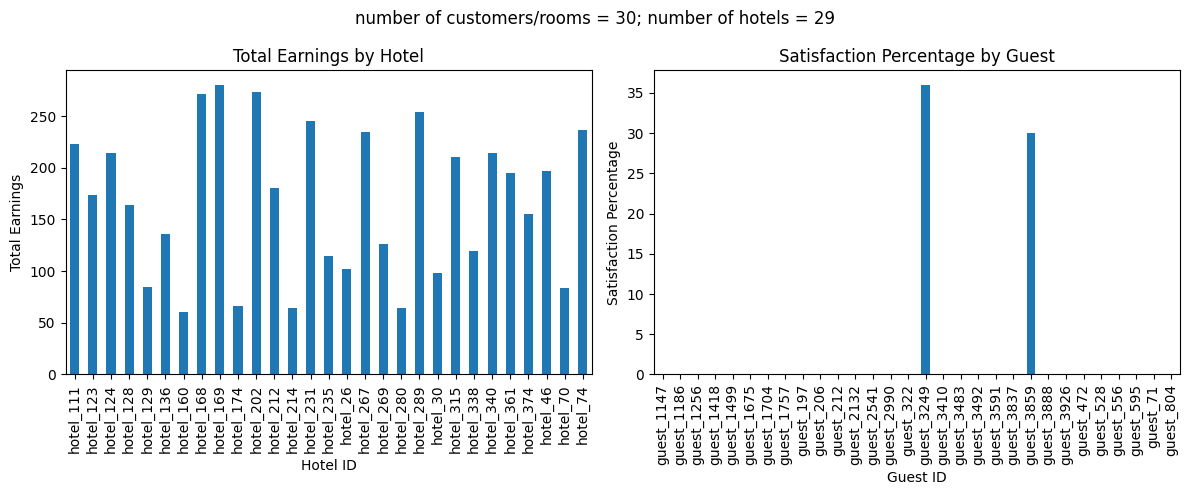

In [12]:
print('Start calculate random allocation')
r_allocator = RandomHotelAllocator(hotelsdata.copy(), guestdata, preferencesdata)
random_allocation = r_allocator.get_random_allocation()
allocation_analysis(random_allocation)
visualize_allocation(random_allocation.head(30))

### b. Availability Allocation

Start calculate availability allocation
Customers accomodated: 4000
Number of rooms occupied: 4000
Number of different hotels occupied: 297
Average satisfaction: 51.19
Total earnings per hotel:
           paid_price
hotel_id             
hotel_1       3177.72
hotel_10      1966.92
hotel_100     2748.80
hotel_101     2087.18
hotel_102     1017.62
...               ...
hotel_93      2847.15
hotel_94      1620.64
hotel_96      2296.32
hotel_97      4095.36
hotel_98      2534.61

[297 rows x 1 columns]


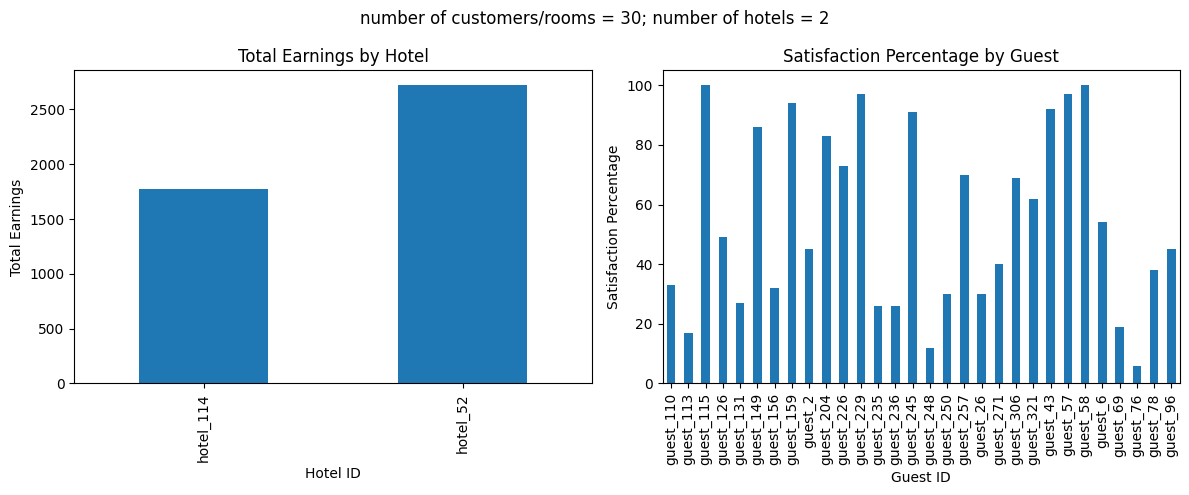

In [13]:
print('Start calculate availability allocation')
a_allocator = HotelAvailabilityAllocator(hotelsdata.copy(), guestdata, preferencesdata)
availability_allocation = a_allocator.get_availability_allocation()
allocation_analysis(availability_allocation)
visualize_allocation(availability_allocation.head(30))

### c. Price Allocation

Start calculate price allocation
Customers accomodated: 4000
Number of rooms occupied: 4000
Number of different hotels occupied: 348
Average satisfaction: 51.87
Total earnings per hotel:
           paid_price
hotel_id             
hotel_10      2084.58
hotel_100     2718.40
hotel_101     2137.74
hotel_102      971.63
hotel_103     1747.25
...               ...
hotel_92       358.72
hotel_94      1580.32
hotel_96      2238.08
hotel_98      2544.66
hotel_99      1035.98

[348 rows x 1 columns]


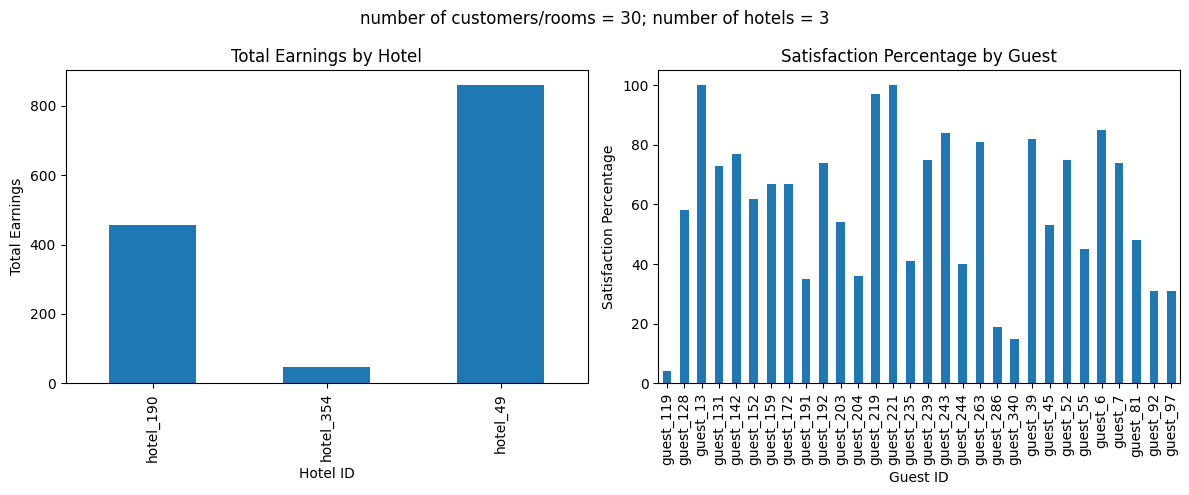

In [14]:
print('Start calculate price allocation')
price_allocator = HotelPriceAllocator(hotelsdata.copy(), guestdata, preferencesdata)
price_allocation = price_allocator.get_price_allocation()
allocation_analysis(price_allocation)
visualize_allocation(price_allocation.head(30))

### d. Preference Allocation

Start calculate preference allocation
Customers accomodated: 3975
Number of rooms occupied: 3975
Number of different hotels occupied: 400
Average satisfaction: 98.11
Total earnings per hotel:
           paid_price
hotel_id             
hotel_1       3128.58
hotel_10      2015.76
hotel_100     1556.80
hotel_101     2164.60
hotel_102     1018.35
...               ...
hotel_95      1350.73
hotel_96      2281.76
hotel_97      4121.28
hotel_98      1849.20
hotel_99      1011.67

[400 rows x 1 columns]


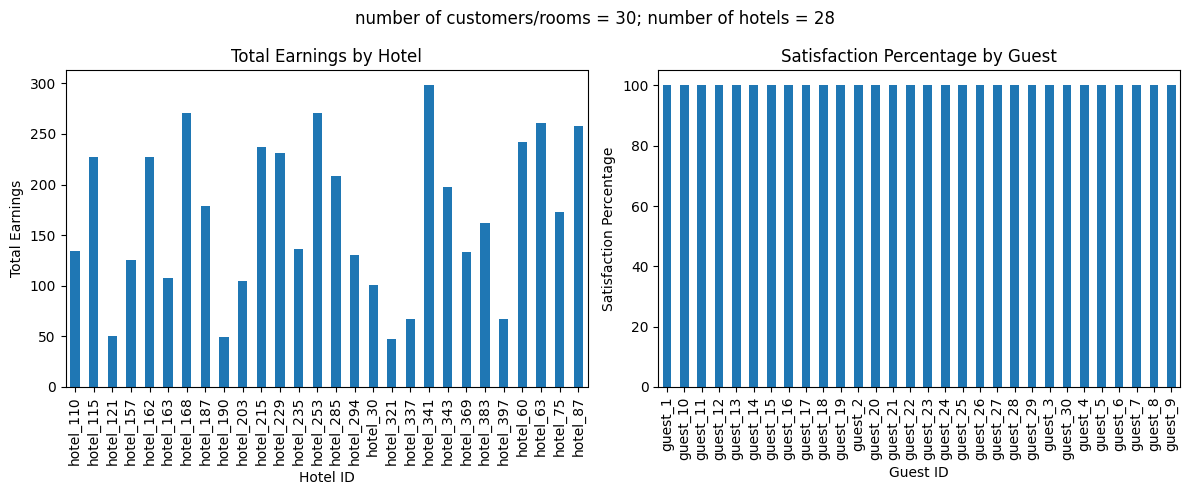

In [15]:
print('Start calculate preference allocation')
pref_allocator = HotelPreferenceAllocator(hotelsdata.copy(), guestdata, preferencesdata)
customer_preference_allocation = pref_allocator.get_customer_preference_allocation()
allocation_analysis(customer_preference_allocation)
visualize_allocation(customer_preference_allocation.head(30))